In [1]:
import pandas as pd
import os
import re
import numpy as np
import pickle

import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RepeatedKFold

from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from collections import Counter

#path = r'C:\Users\chiar\Documents\Università\Text analytics\Data'
path = r'D:\tirocinioLC\tirocinioLC'

In [2]:
df = pd.read_json(path+'\df_final.json')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37693 entries, 1 to 54718
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   ID       37693 non-null  int64              
 1   Title    37690 non-null  object             
 2   Rating   37693 non-null  object             
 3   Author   37693 non-null  object             
 4   Date     37693 non-null  datetime64[ns, UTC]
 5   Chapter  37693 non-null  int64              
 6   Text     37693 non-null  object             
 7   N_Rev    37693 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 2.6+ MB
None


,ID,Title,Rating,Author,Date,Chapter,Text,N_Rev
1,2909917,Rilassati! Hai tutta la morte davanti!,verde,Tonks98,2014-11-15 00:00:00+00:00,1,"""Zi zieda, prego. Allora, quale ezzere zuo ""B...",3
4,1390250,Episodi della Old Generation 1.,verde,mrsreg,2012-11-17 00:00:00+00:00,1,Introduzione. Personaggi: Argus Gazza:...,0
5,1143283,In Noctem,verde,LilacLilium,2012-04-07 00:00:00+00:00,1,Questo mio piccolo lavoretto è ispirato a una ...,2
7,917615,Dirty flower.,verde,Rue,2012-07-01 00:00:00+00:00,1,"DIRTY FLOWER. Lo hai sempre saputo, Lily. ...",3
8,917635,Hawthorn and Unicorn Air,giallo,Tonna,2012-08-01 00:00:00+00:00,1,Before you read: Bentro...,4


In [3]:
df['Popularity'] = df['N_Rev']
col         = 'Popularity'
conditions  = [ (df[col] <= 2) , ((df[col] > 2) & (df[col] < 6)), (df[col] >= 6)]
choices     = [ 'unpopular', 'medium', 'popular' ] 
    
df[col] = np.select(conditions, choices, default=np.nan)

df.head()

,ID,Title,Rating,Author,Date,Chapter,Text,N_Rev,Popularity
1,2909917,Rilassati! Hai tutta la morte davanti!,verde,Tonks98,2014-11-15 00:00:00+00:00,1,"""Zi zieda, prego. Allora, quale ezzere zuo ""B...",3,medium
4,1390250,Episodi della Old Generation 1.,verde,mrsreg,2012-11-17 00:00:00+00:00,1,Introduzione. Personaggi: Argus Gazza:...,0,unpopular
5,1143283,In Noctem,verde,LilacLilium,2012-04-07 00:00:00+00:00,1,Questo mio piccolo lavoretto è ispirato a una ...,2,unpopular
7,917615,Dirty flower.,verde,Rue,2012-07-01 00:00:00+00:00,1,"DIRTY FLOWER. Lo hai sempre saputo, Lily. ...",3,medium
8,917635,Hawthorn and Unicorn Air,giallo,Tonna,2012-08-01 00:00:00+00:00,1,Before you read: Bentro...,4,medium


In [4]:
bdf = df[(df['Popularity']!='medium')]

<AxesSubplot:>

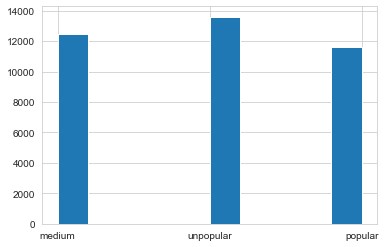

In [5]:
df.Popularity.hist()

# MULTICLASS

In [6]:
target = df[['Popularity']]
del df['Popularity']

In [7]:
#split on train-test 
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.30, random_state=42, stratify=target, shuffle=True) 

In [8]:
print(f"Train set size: {len(x_train)}\nTest set size: {len(x_test)}")

Train set size: 26385
Test set size: 11308


# Preprocessing

## Feature extraction with nltk and spacy

In [9]:
#!python -m spacy download it_core_news_sm

In [10]:
import nltk
import spacy
import re
nlp = spacy.load('it_core_news_sm')

doc_counter = 0
def reset_counter():
  global doc_counter
  doc_counter = 0

def increase_counter():
  global doc_counter
  doc_counter += 1
  if doc_counter % 100 == 0:
    print(doc_counter)

def spacy_nlp_tokenizer(text):
    increase_counter()

    # substituting all space characters with a single space
    text = re.sub('\s+', ' ', text)

    # we use spacy for main nlp tasks
    doc = nlp(text)
    # lemmatized tokens, skipping stopwords
    lemmas = ['LEMMA_'+token.lemma_ for token in doc if not token.is_stop]
    # entity_types
    entity_types = ['NER_'+token.ent_type_ for token in doc if token.ent_type_]

    # in case an entity linker is available, we can use it do put actual entities as
    # features, e.g. Queen Elizabeth, Elizabeth II, Her Majesty -> KB2912
    # see https://spacy.io/usage/training#entity-linker
    # entities = ['ENT_'+token.ent_kb_id_ for token in doc if token.ent_kb_id_]

    # we use a simple nltk function to create ngrams
    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas,3)]

    all_tokens = list()
    all_tokens.extend(lemmas)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    all_tokens.extend(entity_types)
    return all_tokens

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

### Tokenization 

In [12]:
a_file = open(path+r"\x_train_tok_multi.pkl", "rb")
X_train_tok = pickle.load(a_file)

b_file = open(path+r"\x_test_tok_multi.pkl", "rb")
X_test_tok = pickle.load(b_file)

c_file = open(path+r"\vect_multi.pkl", "rb")
vect = pickle.load(c_file)

D:\Anaconda3\envs\ta\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [13]:
print(f"Lunghezza del vocabolario: {len(vect.vocabulary_)}")

Lunghezza del vocabolario: 912978


# Success MULTI Classification

In [14]:
popularity_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=5000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm 
])

reset_counter()
popularity_pipeline.fit(X_train_tok, y_train)
reset_counter()
popularity_predictions = popularity_pipeline.predict(X_test_tok)

D:\Anaconda3\envs\ta\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
print('Classification report:')
print(classification_report(y_test, popularity_predictions))
print('Confusion matrix:')
popularity_cm = confusion_matrix(y_test, popularity_predictions)
print(popularity_cm)

Classification report:
              precision    recall  f1-score   support

      medium       0.36      0.27      0.31      3734
     popular       0.47      0.50      0.48      3493
   unpopular       0.49      0.57      0.53      4081

    accuracy                           0.45     11308
   macro avg       0.44      0.45      0.44     11308
weighted avg       0.44      0.45      0.44     11308

Confusion matrix:
[[1018 1174 1542]
 [ 846 1750  897]
 [ 944  810 2327]]


## Optimization 

In [16]:
search_space = [{'sel__k': [10000, 100000, 250000, 500000, 'all'],
                 'learner':[MultinomialNB()],
                 'learner__alpha': [1e-3, 1e-2, 0.1, 1.0, 10.0],
                 'learner__fit_prior':[True, False]}, 
                {'sel__k': [10000, 100000, 250000, 500000, 'all'],
                 'learner':[LinearSVC()],
                 'learner__C': [0.01, 0.1, 1, 10, 100]},
                {'sel__k': [10000, 100000, 250000, 500000, 'all'], 
                 'learner':[LogisticRegression()],
                 'learner__solver':["liblinear"],
                 'learner__penalty' : ['l1', 'l2'],
                 'learner__C': [0.01, 0.1, 1, 10, 100]} 
               ]

popularity_opt_pipeline = Pipeline([
#    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

scoring = make_scorer(f1_score, greater_is_better=True, pos_label='popular')

In [22]:
popularity_opt_search = GridSearchCV(popularity_opt_pipeline,
                                 search_space,
                                 scoring = scoring,
                                 cv=3, n_jobs = 2, 
                                 verbose=True).fit(X_train_tok,y_train) 

Fitting 3 folds for each of 125 candidates, totalling 375 fits


D:\Anaconda3\envs\ta\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,
D:\Anaconda3\envs\ta\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
popularity_opt_search.best_params_

{'learner': MultinomialNB(alpha=0.001),
 'learner__alpha': 0.001,
 'learner__fit_prior': True,
 'sel__k': 10000}

In [24]:
popularity_opt_search.cv_results_

{'mean_fit_time': array([  2.74698695,   3.45974565,   4.67749627,   7.76423923,
         12.1641403 ,   2.67551152,   3.49664664,   4.90122445,
          7.24762154,  12.18627278,   2.70989585,   3.61832404,
          4.81179722,   7.10927494,  12.7326173 ,   2.71440601,
          3.51799075,   4.67217016,   7.618294  ,  12.2070272 ,
          2.56015499,   3.75628861,   4.70176045,   7.31909545,
         11.90184251,   2.87298234,   3.54784377,   5.0840718 ,
          6.81909982,  12.65802121,   2.71706796,   3.5252374 ,
          4.7210416 ,   7.43681359,  12.41048161,   2.64492702,
          4.01659211,   4.97802075,   7.3762757 ,  11.99608421,
          2.75662629,   3.69711192,   5.16252804,   7.02687605,
         12.38455256,   2.81979052,   3.73268588,   4.80581188,
          7.00362849,  13.59298635,   4.04119333,   5.7758882 ,
          8.12327647,  11.19506335,  20.96194959,   4.95874087,
          6.84203521,   9.79414137,  19.77685984,  30.27757939,
         10.56142879,  

In [25]:
popularity_opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k=10000,
                             score_func=<function chi2 at 0x000001FA54C4F9D8>)),
                ('tfidf', TfidfTransformer()),
                ('learner', MultinomialNB(alpha=0.001))])

In [27]:
popularity_opt_predictions = popularity_opt_search.best_estimator_.predict(X_test_tok)

popularity_correct = 0
popularity_true_labels = [x for x in y_test.Success]

for prediction,popularity_true_labels in zip(popularity_opt_predictions, popularity_true_labels):
    if prediction==popularity_true_labels:
        popularity_correct += 1
        
print(f"Accuracy: {(popularity_correct/len(popularity_opt_predictions)):.2f}")

Accuracy: 0.44


In [28]:
popularity_opt_predictions = popularity_opt_search.best_estimator_.predict(X_test_tok)

print('Classification report:')
print(classification_report(y_test, popularity_opt_predictions))
print('Confusion matrix:')
popularity_opt_cm = confusion_matrix(y_test, popularity_opt_predictions)
print(popularity_opt_cm)

Classification report:
              precision    recall  f1-score   support

      medium       0.37      0.23      0.28      3734
     popular       0.46      0.45      0.45      3493
   unpopular       0.47      0.64      0.54      4081

    accuracy                           0.44     11308
   macro avg       0.43      0.44      0.42     11308
weighted avg       0.43      0.44      0.43     11308

Confusion matrix:
[[ 851 1087 1796]
 [ 765 1568 1160]
 [ 708  769 2604]]


# Classification unpopular vs popular

<AxesSubplot:>

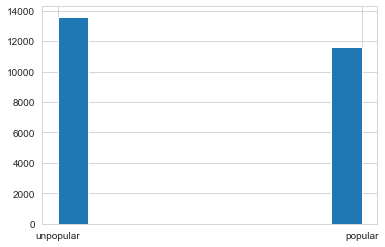

In [14]:
bdf.Popularity.hist()

In [15]:
bdf.Popularity.value_counts()

unpopular    13603
popular      11644
Name: Popularity, dtype: int64

In [16]:
btarget = bdf[['Popularity']]
del bdf['Popularity']

In [17]:
#split on train-test 
x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(bdf, btarget, test_size=0.30, random_state=42, stratify=btarget, shuffle=True) 

In [18]:
print(f"Train set size: {len(x_train_bin)}\nTest set size: {len(x_test_bin)}")

Train set size: 17672
Test set size: 7575


In [19]:
btrain_file = open(path+r"\x_train_bin_tok.pkl", "rb")
x_train_bin_tok = pickle.load(btrain_file)

btest_file = open(path+r"\x_test_bin_tok.pkl", "rb")
x_test_bin_tok = pickle.load(btest_file)

bvect_file = open(path+r"\bvect.pkl", "rb")
bvect = pickle.load(bvect_file)

D:\Anaconda3\envs\ta\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [20]:
print(f"Lunghezza del vocabolario: {len(bvect.vocabulary_)}")

Lunghezza del vocabolario: 636939


In [21]:
popularity_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k='all')),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm 
])

reset_counter()
popularity_pipeline.fit(x_train_bin_tok, y_train_bin.values.ravel())

reset_counter()
popularityb_predictions = popularity_pipeline.predict(x_test_bin_tok)

In [22]:
print('Classification report:')
print(classification_report(y_test_bin, popularityb_predictions))
print('Confusion matrix:')
popularityb_cm = confusion_matrix(y_test_bin, popularityb_predictions)
print(popularityb_cm)

Classification report:
              precision    recall  f1-score   support

     popular       0.70      0.66      0.68      3494
   unpopular       0.72      0.75      0.74      4081

    accuracy                           0.71      7575
   macro avg       0.71      0.71      0.71      7575
weighted avg       0.71      0.71      0.71      7575

Confusion matrix:
[[2310 1184]
 [1002 3079]]


## Inspecting the pipeline 

In [23]:
tokenizer = bvect
selector = popularity_pipeline.named_steps['sel']
classifier = popularity_pipeline.named_steps['learner']

In [24]:
feature_names = tokenizer.get_feature_names()
feats_w_score = list()
for index,(selected,score) in enumerate(zip(selector.get_support(),selector.scores_)):
    feats_w_score.append((score,selected,feature_names[index]))
feats_w_score = sorted(feats_w_score)
len(feats_w_score)

D:\Anaconda3\envs\ta\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


636939

In [25]:
feats_w_classifier_weight = list()
for index,weight in enumerate(selector.inverse_transform(classifier.coef_)[0]):
    if weight!=0:
        feats_w_classifier_weight.append((weight,feature_names[index]))
feats_w_classifier_weight = sorted(feats_w_classifier_weight)
len(feats_w_classifier_weight)

636939

Positive Decision (unpopular)

In [26]:
feats_w_classifier_weight[-100:]

[(0.8737621787457889, 'LEMMA_corto'),
 (0.8752918321191622, 'LEMMA_arrivato'),
 (0.8766635059454473, 'LEMMA_errore'),
 (0.8832669404298342, 'LEMMA_>'),
 (0.885554100548862, 'LEMMA_Albus'),
 (0.8880270403540088, 'LEMMA_rivederti'),
 (0.8897675168829149, 'BI_LEMMA_._LEMMA_Vorrebbe'),
 (0.8910085657735656, 'LEMMA_salvare'),
 (0.8923898663143782, 'BI_LEMMA_regalare_LEMMA_,'),
 (0.8988982347411465, 'LEMMA_e'),
 (0.9010054775469112, 'LEMMA_Corro'),
 (0.9019192562747748, 'BI_LEMMA_Angolo_LEMMA_autrice'),
 (0.9087967432868761, 'TRI_LEMMA_!_LEMMA_”_LEMMA_rispose'),
 (0.9095912348728741, 'LEMMA_Paura'),
 (0.911537480430713, 'LEMMA_cugina'),
 (0.9154660206636434, 'LEMMA_Rebecca'),
 (0.916511930782367, 'BI_LEMMA_”_LEMMA_.'),
 (0.9177107971158555, 'LEMMA_Gazza'),
 (0.9179307937510155, 'TRI_LEMMA_!_LEMMA_»_LEMMA_.'),
 (0.9220038130339221, 'LEMMA_domanda'),
 (0.9220289638075648, 'LEMMA_Amber'),
 (0.9277371582099708, 'LEMMA_sembrare'),
 (0.9285342125952035, 'LEMMA_breve'),
 (0.9286481636333234, 'LEMMA

Negative Decision (popular)

In [27]:
feats_w_classifier_weight[:100]

[(-2.4318850572937007, 'LEMMA_^^'),
 (-2.104726290270603, 'LEMMA_fic'),
 (-1.996838607061957, 'LEMMA_commentare'),
 (-1.8455641824531035, 'LEMMA_dito'),
 (-1.774097760895211, 'LEMMA_dedicare'),
 (-1.6258796334069894, 'LEMMA_XD'),
 (-1.583112269909325, 'LEMMA_Granger'),
 (-1.562197669673614, 'LEMMA_Hermione'),
 (-1.5284863308615548, 'LEMMA_scriverla'),
 (-1.527509441426182, 'LEMMA_scrivere'),
 (-1.5233773241126556, 'LEMMA_shot'),
 (-1.4782829855478006, 'LEMMA_recensione'),
 (-1.4382433837383861, 'LEMMA_classificare'),
 (-1.4359631971718763, 'LEMMA_Tonks'),
 (-1.4306662007416404, 'BI_LEMMA_famiglia_LEMMA_tanto'),
 (-1.4159317932072546, 'BI_LEMMA_!_LEMMA_!'),
 (-1.407274215639175, 'BI_LEMMA_contest_LEMMA_"'),
 (-1.3819962383453215, 'LEMMA_...'),
 (-1.363594399785486, 'LEMMA_drabble'),
 (-1.345282031695674, 'LEMMA_Mezzosangue'),
 (-1.3432359558275462, 'BI_LEMMA_,_LEMMA_e'),
 (-1.32665890840304, 'BI_LEMMA_scrivere_LEMMA_.'),
 (-1.3190768140027371, 'LEMMA_contest'),
 (-1.3119674341481395, 'L

## Optimization 

In [43]:
bpopularity_opt_search = GridSearchCV(popularity_opt_pipeline, 
                                 search_space,
                                 scoring = scoring,
                                 cv=3, n_jobs = 4, verbose=True).fit(x_train_bin_tok, y_train_bin.values.ravel())

Fitting 3 folds for each of 125 candidates, totalling 375 fits


In [44]:
bpopularity_opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k=500000,
                             score_func=<function chi2 at 0x000001B8528E2940>)),
                ('tfidf', TfidfTransformer()),
                ('learner', MultinomialNB(alpha=0.001, fit_prior=False))])

In [46]:
bpopularity_opt_predictions = bpopularity_opt_search.best_estimator_.predict(x_test_bin_tok)

In [47]:
print('Classification report:')
print(classification_report(y_test_bin, bpopularity_opt_predictions))
print('Confusion matrix:')
bpopularity_opt_cm = confusion_matrix(y_test_bin, bpopularity_opt_predictions)
print(bpopularity_opt_cm)

Classification report:
              precision    recall  f1-score   support

     popular       0.62      0.73      0.67      3494
   unpopular       0.73      0.62      0.67      4081

    accuracy                           0.67      7575
   macro avg       0.67      0.67      0.67      7575
weighted avg       0.68      0.67      0.67      7575

Confusion matrix:
[[2534  960]
 [1541 2540]]


## Inspecting the pipeline 

In [48]:
model_opt_pipeline = bpopularity_opt_search.best_estimator_
model_opt_pipeline.fit(x_train_bin_tok, y_train_bin.values.ravel())

Pipeline(steps=[('sel',
                 SelectKBest(k=500000,
                             score_func=<function chi2 at 0x000001B8528E2940>)),
                ('tfidf', TfidfTransformer()),
                ('learner', MultinomialNB(alpha=0.001, fit_prior=False))])

In [49]:
bpopularity_tokenizer = bvect
bpopularity_selector = model_opt_pipeline.named_steps['sel']
bpopularity_classifier = model_opt_pipeline.named_steps['learner']

In [50]:
ratio = bpopularity_classifier.feature_log_prob_[0]/bpopularity_classifier.feature_log_prob_[1]

In [51]:
feats_w_classifier_weight = list()
feature_names = bpopularity_tokenizer.get_feature_names()
for index,weight in enumerate(bpopularity_selector.inverse_transform([ratio])[0]):
    if weight!=0:
        feats_w_classifier_weight.append((weight,feature_names[index]))
feats_w_classifier_weight = sorted(feats_w_classifier_weight)
len(feats_w_classifier_weight)

500000

In [52]:
feats_w_classifier_weight[-100::-1]

[(1.4910410561855643, 'BI_LEMMA_Personaggio_LEMMA_originale'),
 (1.4909758325829616, 'LEMMA_Jocelyn'),
 (1.4889217412580993, 'BI_LEMMA_._LEMMA_Elphias'),
 (1.4879042882472115, 'BI_LEMMA_Corro_LEMMA_...'),
 (1.4876360775049238, 'TRI_LEMMA_,_LEMMA_immaginario_LEMMA_e'),
 (1.4869719690963077, 'TRI_LEMMA_Dumbledore_LEMMA_:_LEMMA_1/1'),
 (1.4865077578226444, 'LEMMA_18Ginny18'),
 (1.4861802531909354, 'TRI_LEMMA_stare_LEMMA_il_LEMMA_amico'),
 (1.4860547403344033, 'LEMMA_urló'),
 (1.4860014867266766, 'LEMMA_Potterhead'),
 (1.4859879583463895, 'TRI_LEMMA_Leggi_LEMMA_1_LEMMA_recensione'),
 (1.4859879583463895, 'TRI_LEMMA_1_LEMMA_recensione_LEMMA_|'),
 (1.4859879583463895, 'BI_LEMMA_Leggi_LEMMA_1'),
 (1.4854006914321451, 'TRI_LEMMA_,_LEMMA_invitare_LEMMA_recensire'),
 (1.4838911544762956, 'TRI_LEMMA_,_LEMMA_11_LEMMA_,'),
 (1.4838225423556972, 'TRI_LEMMA_-_LEMMA_<_LEMMA_<'),
 (1.4830723368384282, 'TRI_LEMMA_Personaggio_LEMMA_originale_LEMMA_.'),
 (1.4829082700901863, 'LEMMA_-0.2'),
 (1.48222318922

In [53]:
feats_w_classifier_weight[:100]

[(0.5733822651427102, 'TRI_LEMMA_|_LEMMA_|_LEMMA_|'),
 (0.6285247801519841, 'LEMMA_roxy_xyz'),
 (0.6286449860520058, 'LEMMA_Asfe'),
 (0.6318665549784805, 'LEMMA_Xevias'),
 (0.632831993150952, 'LEMMA_PV'),
 (0.6366002498354028, 'BI_LEMMA_!_LEMMA_BACIONE'),
 (0.6375592293509299, 'BI_LEMMA_(_LEMMA_PV'),
 (0.6379511747612113, 'LEMMA_Writ'),
 (0.6391343283360493, 'TRI_LEMMA_!_LEMMA_!_LEMMA_BACIONE'),
 (0.6439292589023184, 'BI_LEMMA_Ninna_LEMMA_nanna'),
 (0.6442618257033491, 'LEMMA_TRADOTTO'),
 (0.6451154758166353, 'LEMMA_missmalfoy'),
 (0.6453044286876266, 'BI_LEMMA_._LEMMA_Eterosessuale'),
 (0.6455921010304752, 'BI_LEMMA_Nonna_LEMMA_Minerva'),
 (0.6458170875374489, 'BI_LEMMA_^^_LEMMA_Xevias'),
 (0.645835942582516, 'TRI_LEMMA_,_LEMMA_100_LEMMA_parola'),
 (0.646227714117341, 'BI_LEMMA_"_LEMMA_Luca'),
 (0.646227714117341, 'BI_LEMMA_AMORE_LEMMA_TRADOTTO'),
 (0.646227714117341, 'BI_LEMMA_Luca_LEMMA_Clementi'),
 (0.646227714117341, 'BI_LEMMA_TRADOTTO_LEMMA_"'),
 (0.646227714117341, 'LEMMA_Clemen